# Changing the power parameter

Loading in modules and configurating:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.interpolate import griddata
from deepxde.backend import tf

import deepxde as dde
dde.config.set_default_float("float64")
dde.config.set_random_seed(123456789)

import seaborn as sns
sns.set_context("talk")

Using backend: tensorflow.compat.v1

2023-03-20 13:58:33.940165: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Instructions for updating:
non-resource variables are not supported in the long term


2023-03-20 13:59:26.497872: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-20 13:59:26.501001: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-03-20 13:59:26.608988: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:43:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-03-20 13:59:26.609032: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-03-20 13:59:28.502162: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-03-20 13:59:28.502254: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.

Enable just-in-time compilation with XLA.





Set the default float type to float64


## Geometry

Using a 

In [2]:
x_max = 1e-3
y_max = 0.23e-3
z_max = 0.1e-3
P_min = 100
P_max = 300

geo = dde.geometry.Hypercube((0.0, 0.0, 0.0, P_min), (x_max, y_max, z_max, P_max))

In [3]:
t_max = 0.002

time = dde.geometry.TimeDomain(0, t_max)
domain = dde.geometry.GeometryXTime(geo, time)

## Parameters 

In [4]:
A = 0.09
D = 140e-6
R = D/2
v = 200e-3
T_0 = 273.15

## PDE

In [5]:
def pde_system(X, output):
    
    T = output
    
    dT_dx = dde.grad.jacobian(T, X, j = 0)
    dT_dy = dde.grad.jacobian(T, X, j = 1)
    dT_dz = dde.grad.jacobian(T, X, j = 2)
    dT_dt = dde.grad.jacobian(T, X, j = 4)
       
    k = (11.82+1.06e-2*T)
    c = (330.9+0.563*T-4.015e-4*T**2+9.465e-8*T**3)
    rho = 7800.0*T**0
    
    k_eff = 0.6*k
    rho_eff = 0.6*rho
    
    diff_T = dde.grad.jacobian(k_eff*dT_dx, X, j = 0) + dde.grad.jacobian(k_eff*dT_dy, X, j=1) + dde.grad.jacobian(k_eff*dT_dz, X, j = 2)
    
    f_T = dT_dt - diff_T/(rho_eff*c)# + 272e3/(c**2*rho)*tf.cast(molten, 'float64')
        
    return f_T

## Boundary Condition

In [6]:
def top_bc(X, Y):
    
    r_sq = (X[:,0:1] - x_max/4 - X[:,4:5]*v)**2 + (X[:,1:2] - y_max/2)**2
    k = (11.82+1.06e-2*Y)
    k_eff = 0.6*k
    return 2*A*X[:,3:4]/(np.pi*R**2)*tf.exp(-2*r_sq/R**2)/k_eff

top = dde.icbc.RobinBC(domain, lambda X, Y : top_bc(X, Y), lambda x, on_boundary: np.isclose(x[2], z_max, atol=z_max/40))

In [7]:
data = dde.data.TimePDE(domain,
                       pde_system,
                       ic_bcs = [top],
                       num_domain = 10,
                       num_initial = 0,
                       num_boundary = 0,
                       train_distribution="Hammersley")

points = data.train_points().T

In [8]:
net = dde.nn.FNN([5] + [40] * 6 + [1], "sin", "Glorot normal")

def feature_transform(X):
    return tf.concat(
        [(X[:, 0:1]/x_max - 0.5), 
         (X[:, 1:2]/y_max - 0.5),
         (X[:, 2:3]/z_max - 0.5),
         (X[:, 3:4]/(P_max-P_min) - 0.5),
         (X[:, 4:5]/t_max - 0.5)], axis=1
    )
net.apply_feature_transform(feature_transform)

def modify_output(X, Y):
    x, y, z, p, t = X[:, 0:1], X[:, 1:2], X[:, 2:3], X[:, 3:4], X[:, 4:5]
    Temperature = Y
    T_new = 20.0 + T_0 - Temperature*5e23*x*y*(x-x_max)*(y-y_max)*t*z*p
    return tf.concat(T_new, axis = 1)
net.apply_output_transform(modify_output)

model = dde.Model(data, net)
model.compile("adam", lr=1e-5)
losshistory, train_state = model.train(epochs=0, display_every=1000)
weights = 1/np.array(losshistory.loss_train[0])

Compiling model...
Building feed-forward neural network...
'build' took 0.270317 s



/home/sc.uni-leipzig.de/nl220wxeo/.conda/envs/dde/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/sc.uni-leipzig.de/nl220wxeo/.conda/envs/dde/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2023-03-20 13:59:53.409896: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 13:

'compile' took 19.365078 s

Initializing variables...


2023-03-20 14:00:12.724140: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
2023-03-20 14:00:13.068884: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000074999 Hz


Training model...



2023-03-20 14:00:15.392556: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x153ce400d590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-20 14:00:15.392604: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-03-20 14:00:16.854323: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-03-20 14:00:26.202160: I tensorflow/compiler/jit/xla_compilation_cache.cc:333] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss              Test loss               Test metric
0         [2.47e+12, nan]         [2.47e+12, nan]         []  

Best model at step 0:
  train loss: inf
  test loss: inf
  test metric: 

'train' took 16.784040 s



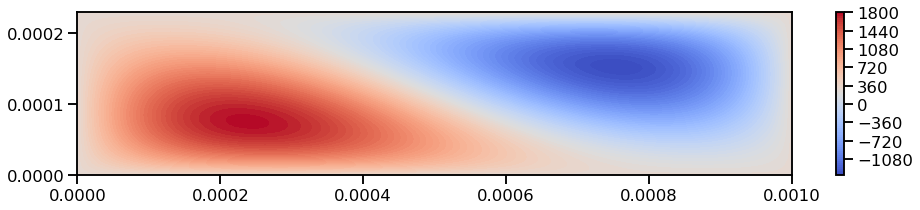

In [9]:
x_lin = np.linspace(0, x_max)
y_lin = np.linspace(0, y_max)
xx, yy, zz, pp, tt = np.meshgrid(x_lin, y_lin, [z_max], [100], [t_max])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(pp), np.ravel(tt))).T

Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
predict = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

plt.figure(figsize = (16, 3))
plt.contourf(xi, yi, predict, 100, cmap=plt.cm.coolwarm)
plt.colorbar()

In [10]:
model.restore('laser_power/laser_power-31380.ckpt')

INFO:tensorflow:Restoring parameters from laser_power/laser_power-31380.ckpt


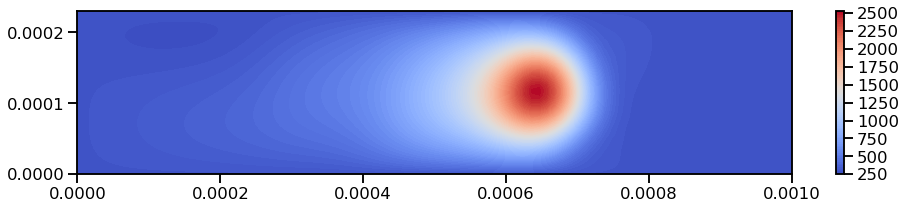

In [11]:
x_lin = np.linspace(0, x_max)
y_lin = np.linspace(0, y_max)
xx, yy, zz, pp, tt = np.meshgrid(x_lin, y_lin, [z_max], [100], [t_max])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(pp), np.ravel(tt))).T

Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
predict = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

plt.figure(figsize = (16, 3))
plt.contourf(xi, yi, predict, 100, cmap=plt.cm.coolwarm)
plt.colorbar()

In [12]:
net.num_trainable_parameters()

8481

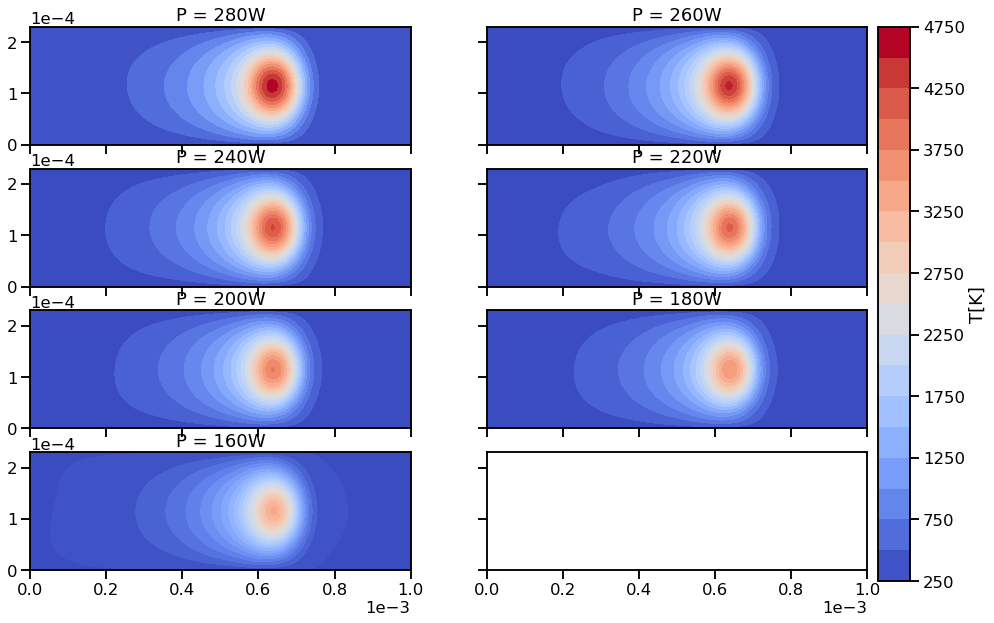

In [13]:
fig, axes = plt.subplots(ncols = 2, nrows = 4, figsize = (15, 10), sharex=True, sharey=True)

powers = [i for i in range(160, 300, 20)]

data = np.genfromtxt('surface_fields/surface_200.csv', delimiter = ',',skip_header = True)
x, y, z, T = data[:, 0], data[:, 1], data[:, 2], data[:, 3]

for power, ax in zip(reversed(powers), axes.flatten()):

    T_pre = np.load('surface_fields/prelearn/{}.npy'.format(power))
    if power == 280:
        T_max = T_pre.max()
        T_min = T_pre.min()
        
    xi = np.linspace(x.min(), x.max(), 100)
    yi = np.linspace(y.min(), y.max(), 100)
    #Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')

    #Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')
    T_pred = griddata((x, y), T_pre, (xi[None,:], yi[:,None]), method='cubic')
    ax.ticklabel_format(style='sci',  scilimits=(0, 0))
    ax.set_title('P = {}W'.format(power))
    im = ax.contourf(xi, yi, T_pred, 20, cmap=plt.cm.coolwarm, vmin=T_min, vmax=T_max)
    if power == 280:
        cbar_ax = fig.add_axes([0.91, 0.11, 0.03, 0.77])
        fig.colorbar(im, cax=cbar_ax)
        cbar_ax.set_ylabel('T[K]')

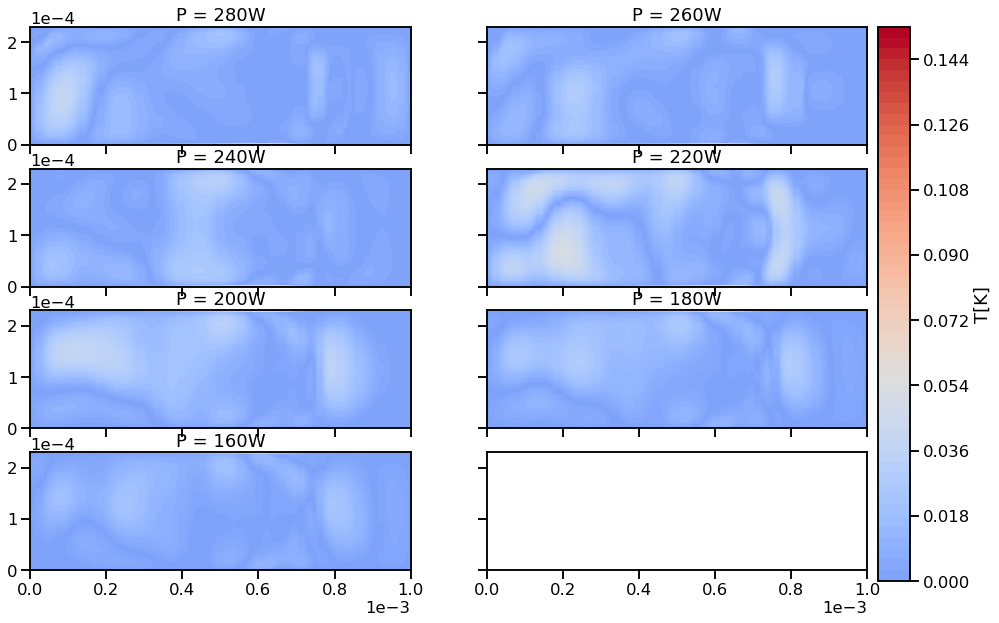

In [14]:
fig, axes = plt.subplots(ncols = 2, nrows = 4, figsize = (15, 10), sharex=True, sharey=True)

powers = [i for i in range(160, 300, 20)]
errors = []
for power, ax in zip(reversed(powers), axes.flatten()):

    data = np.genfromtxt('surface_fields/surface_{}.csv'.format(power), delimiter = ',',skip_header = True)
    x, y, z, T = data[:, 0], data[:, 1], data[:, 2], data[:, 3]

    T_pre = np.load('surface_fields/prelearn/{}.npy'.format(power))
    if power == 280:
        T_max = ((T-T_pre)/T).max()
        T_min = ((T-T_pre)/T).min()
        
    xi = np.linspace(x.min(), x.max(), 100)
    yi = np.linspace(y.min(), y.max(), 100)
    #Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')

    errors.append(np.abs(T-T_pre)/T)
    #Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')
    T_pred = griddata((x, y), np.abs(T-T_pre)/T, (xi[None,:], yi[:,None]), method='nearest')
    ax.ticklabel_format(style='sci',  scilimits=(0, 0))
    ax.set_title('P = {}W'.format(power))
    im = ax.contourf(xi, yi, T_pred, 50, cmap=plt.cm.coolwarm, vmin=T_min, vmax=T_max)
    if power == 280:
        cbar_ax = fig.add_axes([0.91, 0.11, 0.03, 0.77])
        fig.colorbar(im, cax=cbar_ax)
        cbar_ax.set_ylabel('T[K]')
        
errors = np.array(errors)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


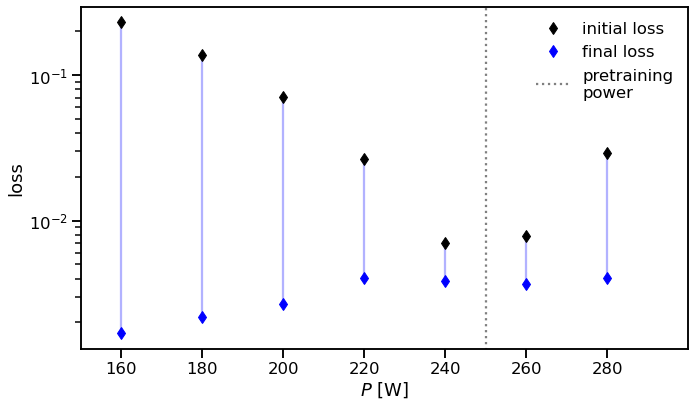

In [16]:
errors_filtered = np.ma.masked_greater(errors, 0.006)

fig, (ax1) = plt.subplots(ncols = 1, figsize = (10, 6))
ax1.set_yscale('log')
                                                             
n = 4
n2 = 5

for p in powers:
    
    loss = np.load('surface_fields/losses/train_{}.npy'.format(p))
    loss = loss/10**13
    ax1.plot([p, p], [loss.T[0][n] + loss.T[1][n], loss.T[0][-1] + loss.T[1][-1]], 
             #label = 'P={}W'.format(p), 
             marker = '', 
             alpha=0.3, 
             linestyle='-',
            color = 'blue')
    
    ax1.plot(p, loss.T[0][n:n2] + loss.T[1][n:n2], 
             #label = 'P={}W'.format(p), 
             marker = 'd', 
             alpha=1, 
             linestyle='',
            color = 'black',
            label = 'initial loss' * (p == 160))
    
    ax1.plot(p, loss.T[0][-1] + loss.T[1][-1], 
             #label = 'P={}W'.format(p), 
             marker = 'd', 
             alpha=1, 
             linestyle='',
            color = 'blue',
            label = 'final loss' * (p == 160))

ax1.set_ylim(ax1.get_ylim()) 
ax1.vlines([250], 0.8*10**-3, 0.5*10**1, color = 'grey', linestyle = 'dotted', label = 'pretraining\npower')

ax1.set_xticks([i for i in reversed(powers)])
ax1.set_xlim(150, 300)
#ax1.text(237, 10.1**14, 'pretraining at', color = 'red')
ax1.legend(frameon=False, loc = 'upper right')

ax1.set_xlabel(r'$P$ [W]')
ax1.set_ylabel(r'loss')
 
plt.tight_layout()
plt.savefig('variation/pretrain_ana.eps', bbox_inches='tight')

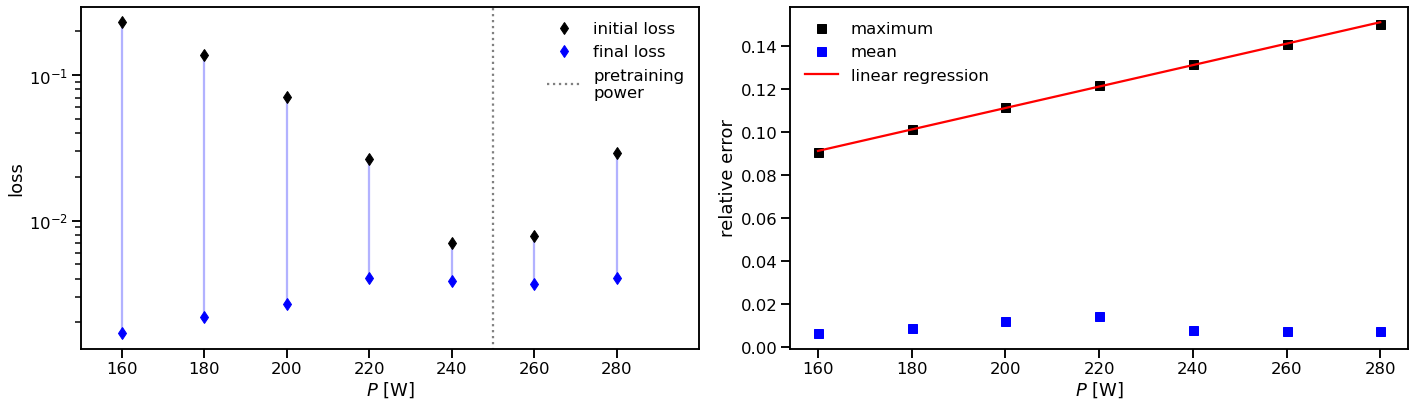

In [15]:
errors_filtered = np.ma.masked_greater(errors, 0.006)

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (20, 6))
ax1.set_yscale('log')

#ax2.plot([i for i in reversed(powers)], np.ma.mean(errors_filtered, axis = 1).data, 'r+')
ax2.plot([i for i in reversed(powers)], np.max(errors, axis = 1), 'ks', label = 'maximum')
ax2.plot([i for i in reversed(powers)], np.mean(errors, axis = 1), 'bs', label = 'mean')
ax2.set_xticks([i for i in reversed(powers)])
ax2.set_ylabel('relative error')
ax2.set_xlabel((r'$P$ [W]'))

from scipy.stats import linregress

linreg = linregress([i for i in reversed(powers)], np.max(errors, axis = 1))

ax2.plot(np.array([i for i in reversed(powers)]), 
         np.array([i for i in reversed(powers)])*linreg.slope + linreg.intercept, 'r-', label = 'linear regression')
"""ax2.fill_between(np.array([i for i in reversed(powers)]), 
                 np.array([i for i in reversed(powers)])*(linreg.slope+linreg.stderr) + linreg.intercept+linreg.intercept_stderr,  
                 np.array([i for i in reversed(powers)])*(linreg.slope-linreg.stderr) + linreg.intercept-linreg.intercept_stderr,
                color = 'red',
                alpha = 0.2)"""
ax2.legend(frameon=False)                                                                             
n = 4
n2 = 5

for p in powers:
    
    loss = np.load('surface_fields/losses/train_{}.npy'.format(p))
    loss = loss/10**13
    ax1.plot([p, p], [loss.T[0][n] + loss.T[1][n], loss.T[0][-1] + loss.T[1][-1]], 
             #label = 'P={}W'.format(p), 
             marker = '', 
             alpha=0.3, 
             linestyle='-',
            color = 'blue')
    
    ax1.plot(p, loss.T[0][n:n2] + loss.T[1][n:n2], 
             #label = 'P={}W'.format(p), 
             marker = 'd', 
             alpha=1, 
             linestyle='',
            color = 'black',
            label = 'initial loss' * (p == 160))
    
    ax1.plot(p, loss.T[0][-1] + loss.T[1][-1], 
             #label = 'P={}W'.format(p), 
             marker = 'd', 
             alpha=1, 
             linestyle='',
            color = 'blue',
            label = 'final loss' * (p == 160))
    #ax1.plot(loss.T[1][n:n2], label = 'P={}W'.format(p), marker = '', linestyle='-')
    
ax1.set_ylim(ax1.get_ylim()) 
ax1.vlines([250], 0.8*10**-3, 0.5*10**1, color = 'grey', linestyle = 'dotted', label = 'pretraining\npower')

ax2.set_ylim(ax2.get_ylim())
ax2.vlines([250], 0.7*10**10, 10**14, color = 'grey', linestyle = 'dotted', label = 'pretraining\npower')
#ax1.set_ylim([0.7*10**10, 10**14])
ax1.set_xticks([i for i in reversed(powers)])
ax1.set_xlim(150, 300)
#ax1.text(237, 10.1**14, 'pretraining at', color = 'red')
ax1.legend(frameon=False, loc = 'upper right')

ax1.set_xlabel(r'$P$ [W]')
ax1.set_ylabel(r'loss')
 
plt.tight_layout()
plt.savefig('variation/pretrain_ana.pdf', bbox_inches='tight')

In [18]:
linreg

LinregressResult(slope=0.000498629056100261, intercept=0.011621075483573204, rvalue=0.9996707586880627, pvalue=3.777139668157789e-09, stderr=5.72363592505567e-06, intercept_stderr=0.001279843900688437)

In [19]:
loss_test = np.load('losses/power_losses/test_loss.npy')
loss_train = np.load('losses/power_losses/train_loss.npy')
iterations = np.arange(len(loss_train))*100

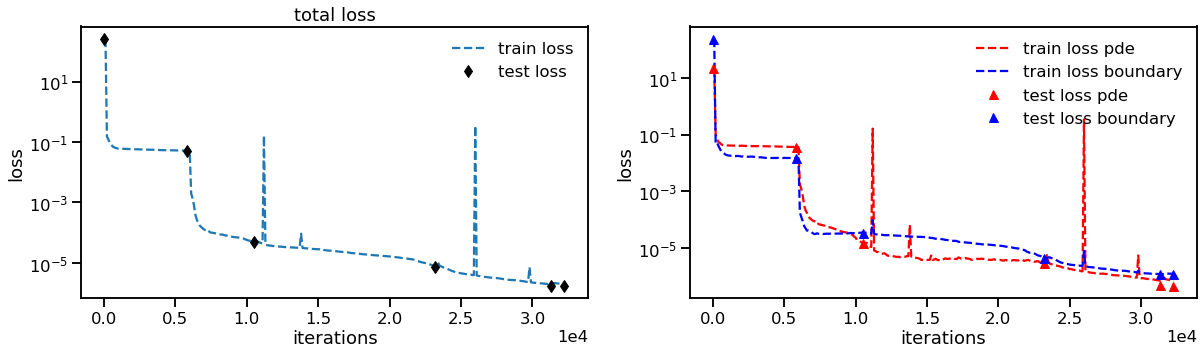

In [38]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (20, 5))

net_losses = loss_test.sum(axis=1)[1:]
x_values = np.arange(0, len(net_losses), 1)
values, index = np.unique(net_losses, return_index=True)
index = sorted(index)

ax1.plot(iterations[1:], loss_train.sum(axis=1)[1:], linestyle = '--', label = 'train loss')
ax1.plot(iterations[index], net_losses[index], 'kd', label = 'test loss', alpha = 1)

ax1.set_yscale('log')
#ax1.grid()
ax1.legend(frameon=False)
ax1.set_title('total loss')
ax1.set_ylabel('loss')

ax2.plot(iterations[1:], loss_train.T[0, 1:], '--', label = 'train loss pde', color = 'red')
ax2.plot(iterations[1:], loss_train.T[1, 1:], label = 'train loss boundary', linestyle = '--', color = 'blue')

ax2.plot(iterations[index], loss_test.T[0, 1:][index], 'r^', label = 'test loss pde', alpha = 1)
ax2.plot(iterations[index], loss_test.T[1, 1:][index], 'b^', label = 'test loss boundary', alpha = 1)

ax2.set_yscale('log')
#ax2.grid()
ax2.legend(frameon=False)
ax2.set_ylabel('loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('iterations')
ax1.set_xlabel('iterations')
ax1.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
plt.savefig('variation/power_losses.pdf', bbox_inches='tight')

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.11 µs


(0.00045, 0.00075, 0.0, 0.00023)

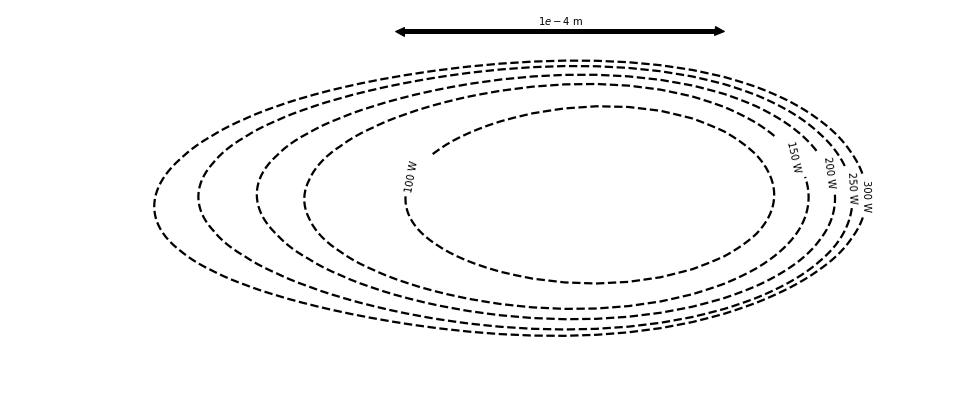

In [24]:
%time
#%matplotlib widget
%matplotlib inline

x_lin = np.linspace(0, x_max, 100)
y_lin = np.linspace(0, y_max, 100)

fig, (ax1) = plt.subplots(figsize = (17, 7))
dx = 2e-4
for i in range(100, 301, 50):

    xx, yy, zz, pp, tt = np.meshgrid(x_lin, y_lin, [z_max], [i], [t_max])
    X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(pp), np.ravel(tt))).T
    Y = model.predict(X)
    xi = np.linspace(xx.min(), xx.max(), 100)
    yi = np.linspace(yy.min(), yy.max(), 100)
    predict = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='linear')
    im = ax1.contour(xi, yi, predict, [1633], linestyles='--', colors='black')
    ax1.clabel(im, inline=True, fontsize=10, fmt=lambda x : str(i)+ ' W')
    #plt.title('P={}W'.format(i))

plt.hlines(([1.5e-5+dx]), 5.75e-4, 6.75e-4, color='black', linewidth=5)
plt.text(6.25e-4, 4e-6+1.5e-5+dx, r'$1e-4$ m', ha='center', fontsize=10)
plt.plot([5.74e-4], [1.52e-5+dx], 'k<')
plt.plot([6.75e-4], [1.52e-5+dx], 'k>')
ax1.set_xlim((4.5e-4, 7.5e-4))
plt.axis('off')
#plt.savefig('variation/pool.pdf', bbox_inches='tight')

2023-03-20 14:06:22.274787: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


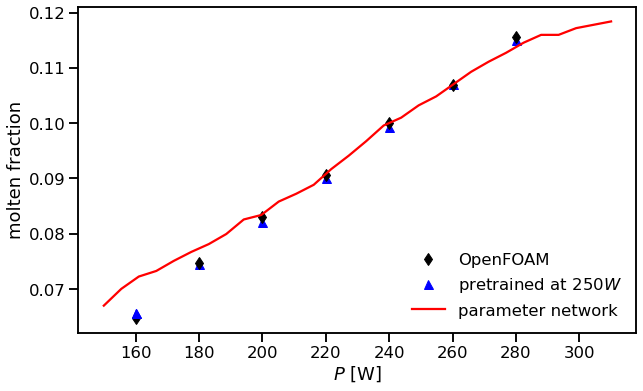

In [17]:
fig, (ax1) = plt.subplots(ncols = 1, figsize = (10, 6))

powers = [i for i in range(160, 300, 20)]

for power in powers:

    data = np.genfromtxt('surface_fields/surface_{}.csv'.format(power), delimiter = ',',skip_header = True)
    x, y, z, T = data[:, 0], data[:, 1], data[:, 2], data[:, 3]
    
    X = np.vstack((x, y, np.ones(len(x))*z.max(),np.ones(len(x))*power, np.ones(len(x))*t_max)).T
    Y = model.predict(X)

    T_pre = np.load('surface_fields/prelearn/{}.npy'.format(power))
    ax1.plot(power, np.sum(T_pre>1693)/len(T_pre), 'b^')
        
    if power == 160:
        T_pre = np.load('surface_fields/prelearn/{}.npy'.format(power))
        ax1.plot(power, np.sum(T>1693.0)/len(T_pre), 'kd', label = 'OpenFOAM', alpha = 1)
        ax1.plot(power, np.sum(T_pre>1693.0)/len(T_pre), 'b^', label = 'pretrained at $250W$')

    else:
        ax1.plot(power, np.sum(T>1693.0)/len(T_pre), 'kd', alpha = 1)

powers_fine = np.linspace(150, 310, 30)
temps = []
for power in powers_fine:
    X = np.vstack((x, y, np.ones(len(x))*z.max(),np.ones(len(x))*power, np.ones(len(x))*t_max)).T
    Y = model.predict(X)
    temps.append(np.sum(Y>1693.0)/len(T_pre))
    
ax1.plot(powers_fine, temps, 'r-', label = 'parameter network')
#ax1.set_ylim([3250, 4750])
#ax1.vlines([200], 3000, 5000, color = 'black', alpha=0.5, label = 'center of the training intervall')
ax1.set_xlabel('$P$ [W]')
ax1.set_ylabel('molten fraction')
#ax1.grid()
ax1.legend(loc='lower right', frameon=False)

plt.savefig('variation/power_para_molten.eps', bbox_inches='tight')

2023-03-01 10:52:57.884008: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


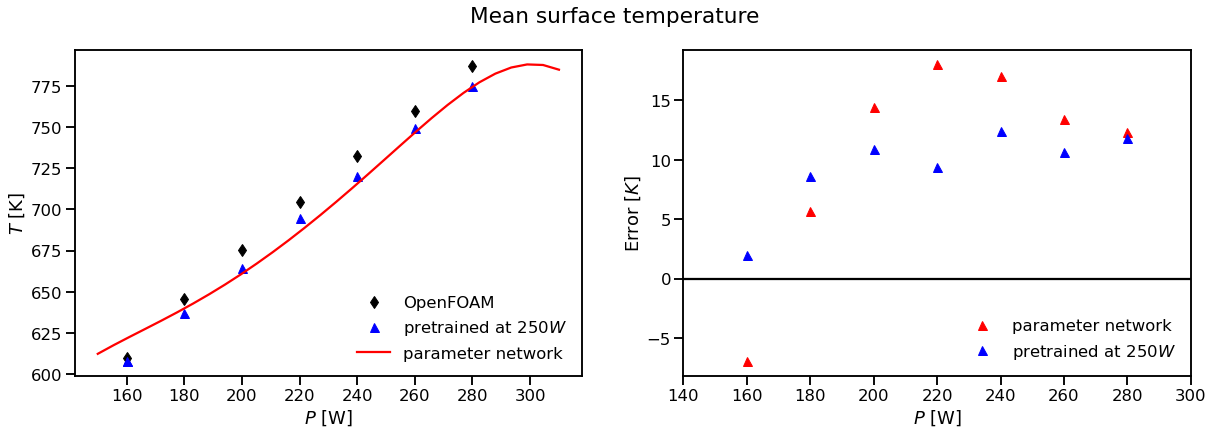

In [16]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (20, 6))

powers = [i for i in range(160, 300, 20)]
fig.suptitle('Mean surface temperature')
for power in powers:

    data = np.genfromtxt('surface_fields_2/surface_{}.csv'.format(power), delimiter = ',',skip_header = True)
    x, y, z, T = data[:, 0], data[:, 1], data[:, 2], data[:, 3]
    
    X = np.vstack((x, y, np.ones(len(x))*z.max(),np.ones(len(x))*power, np.ones(len(x))*t_max)).T
    Y = model.predict(X)

    T_pre = np.load('surface_fields/prelearn/{}.npy'.format(power))
    ax1.plot(power, T_pre.mean(), 'b^')
        
    if power == 160:
        T_pre = np.load('surface_fields/prelearn/{}.npy'.format(power))
        ax1.plot(power, T.mean(), 'kd', label = 'OpenFOAM', alpha = 1)
        ax1.plot(power, T_pre.mean(), 'b^', label = 'pretrained at $250W$')
        ax2.plot(power, (T.mean() - Y.mean()), 'r^', label = 'parameter network')
        ax2.plot(power, (T.mean() - T_pre.mean()), 'b^', label = 'pretrained at $250W$')
    else:
        ax1.plot(power, T.mean(), 'kd', alpha = 1)
        ax2.plot(power, np.abs((T.mean() - Y.mean())), 'r^')
        ax2.plot(power, np.abs((T.mean() - T_pre.mean())), 'b^')

powers_fine = np.linspace(150, 310, 30)
temps = []
for power in powers_fine:
    X = np.vstack((x, y, np.ones(len(x))*z.max(),np.ones(len(x))*power, np.ones(len(x))*t_max)).T
    Y = model.predict(X)
    temps.append(Y.mean())
    
ax1.plot(powers_fine, temps, 'r-', label = 'parameter network')
#ax1.set_ylim([3250, 4750])
#ax1.vlines([200], 3000, 5000, color = 'black', alpha=0.5, label = 'center of the training intervall')
ax1.set_xlabel('$P$ [W]')
ax1.set_ylabel('$T$ [K]')
#ax1.grid()
ax1.legend(loc='lower right', frameon=False)

#ax2.grid()
ax2.hlines([0], 140, 300, color = 'black')
ax2.legend(frameon=False)

ax2.set_xlim([140, 300])
ax2.set_ylabel(r'Error $[K]$')
ax2.set_xlabel('$P$ [W]')

plt.savefig('variation/power_para.pdf', bbox_inches='tight')

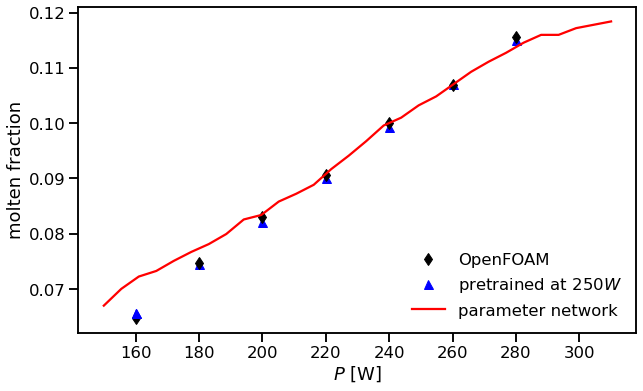

In [37]:
fig, (ax1) = plt.subplots(ncols = 1, figsize = (10, 6))

powers = [i for i in range(160, 300, 20)]

for power in powers:

    data = np.genfromtxt('surface_fields/surface_{}.csv'.format(power), delimiter = ',',skip_header = True)
    x, y, z, T = data[:, 0], data[:, 1], data[:, 2], data[:, 3]
    
    X = np.vstack((x, y, np.ones(len(x))*z.max(),np.ones(len(x))*power, np.ones(len(x))*t_max)).T
    Y = model.predict(X)

    T_pre = np.load('surface_fields/prelearn/{}.npy'.format(power))
    ax1.plot(power, np.sum(T_pre>1693)/len(T_pre), 'b^')
        
    if power == 160:
        T_pre = np.load('surface_fields/prelearn/{}.npy'.format(power))
        ax1.plot(power, np.sum(T>1693.0)/len(T_pre), 'kd', label = 'OpenFOAM', alpha = 1)
        ax1.plot(power, np.sum(T_pre>1693.0)/len(T_pre), 'b^', label = 'pretrained at $250W$')

    else:
        ax1.plot(power, np.sum(T>1693.0)/len(T_pre), 'kd', alpha = 1)

powers_fine = np.linspace(150, 310, 30)
temps = []
for power in powers_fine:
    X = np.vstack((x, y, np.ones(len(x))*z.max(),np.ones(len(x))*power, np.ones(len(x))*t_max)).T
    Y = model.predict(X)
    temps.append(np.sum(Y>1693.0)/len(T_pre))
    
ax1.plot(powers_fine, temps, 'r-', label = 'parameter network')
#ax1.set_ylim([3250, 4750])
#ax1.vlines([200], 3000, 5000, color = 'black', alpha=0.5, label = 'center of the training intervall')
ax1.set_xlabel('$P$ [W]')
ax1.set_ylabel('molten fraction')
#ax1.grid()
ax1.legend(loc='lower right', frameon=False)

plt.savefig('variation/power_para_molten.pdf', bbox_inches='tight')

In [ ]:
fig, (ax1) = plt.subplots(ncols = 1, figsize = (10, 6))

powers = [i for i in range(160, 300, 20)]

for power in powers:

    data = np.genfromtxt('surface_fields/surface_{}.csv'.format(power), delimiter = ',',skip_header = True)
    x, y, z, T = data[:, 0], data[:, 1], data[:, 2], data[:, 3]
    
    X = np.vstack((x, y, np.ones(len(x))*z.max(),np.ones(len(x))*power, np.ones(len(x))*t_max)).T
    Y = model.predict(X)

    T_pre = np.load('surface_fields/prelearn/{}.npy'.format(power))
    ax1.plot(power, np.sum(T_pre>1693)/len(T_pre), 'b^')
        
    if power == 160:
        T_pre = np.load('surface_fields/prelearn/{}.npy'.format(power))
        ax1.plot(power, np.sum(T>1693.0)/len(T_pre), 'kd', label = 'OpenFOAM', alpha = 1)
        ax1.plot(power, np.sum(T_pre>1693.0)/len(T_pre), 'b^', label = 'pretrained at $250W$')

    else:
        ax1.plot(power, np.sum(T>1693.0)/len(T_pre), 'kd', alpha = 1)

powers_fine = np.linspace(150, 310, 30)
temps = []
for power in powers_fine:
    X = np.vstack((x, y, np.ones(len(x))*z.max(),np.ones(len(x))*power, np.ones(len(x))*t_max)).T
    Y = model.predict(X)
    temps.append(np.sum(Y>1693.0)/len(T_pre))
    
ax1.plot(powers_fine, temps, 'r-', label = 'parameter network')
#ax1.set_ylim([3250, 4750])
#ax1.vlines([200], 3000, 5000, color = 'black', alpha=0.5, label = 'center of the training intervall')
ax1.set_xlabel('$P$ [W]')
ax1.set_ylabel('molten fraction')
#ax1.grid()
ax1.legend(loc='lower right', frameon=False)

plt.savefig('variation/power_para_molten.esp', bbox_inches='tight')

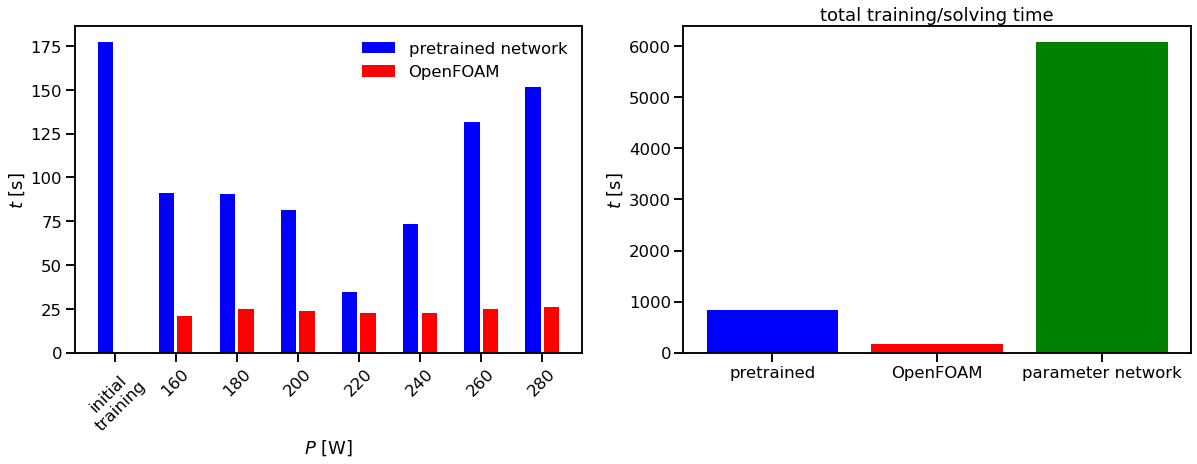

In [45]:
powers_prelearn = [160, 180, 200, 220, 240, 260, 280]

initial_pinn_time = 45.677560 + 26.986444 + 8.558346 + 41.209458 + 27.610473 + 27.309398

times_prelearn = [91.103324, 
                  90.399368, 
                  81.385084, 
                  34.632583,
                  73.612936,
                  131.688038,
                  151.825496]
#times_of = [4627.54, 4640.5, 2231.8, 4639.55, 4632.47, 2024.03, 2023.37]

times_of = [20.66, 25.14, 23.85, 22.87, 22.45, 24.86, 26.04]
time_parameter_network = [1051.359525+834.412331+2395.566730+1623.754743+180.392660]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (20, 6))

ax1.bar(np.array(powers_prelearn)-3, times_prelearn, width = 5, label = 'pretrained network', color = 'blue')
ax1.bar(np.array(powers_prelearn)+3, times_of, width = 5, label = 'OpenFOAM', color = 'red')
ax1.bar(140-3, [initial_pinn_time], width = 5, color = 'blue')
ax1.set_xticks([140] + powers_prelearn)
ax1.set_xticklabels(['initial\ntraining'] + powers_prelearn, rotation = 45)
ax1.set_xlabel('$P$ [W]')
ax1.set_ylabel('$t$ [s]')
ax1.legend(ncol=1, framealpha=0)

ax2.set_title('total training/solving time')
ax2.set_ylabel('$t$ [s]')
ax2.bar([1], [np.sum(times_prelearn) + initial_pinn_time], label = 'pretrained networks', color = 'blue')
ax2.bar([2], [np.sum(times_of)], label =  'OpenFOAM', color = 'red')
ax2.bar([3], time_parameter_network, label =  'parameter network', color = 'green')

ax2.set_xticks([1, 2, 3])
ax2.set_xticklabels(['pretrained', 'OpenFOAM', 'parameter network'])

plt.savefig('variation/training_times.pdf', bbox_inches='tight')